In [1]:
import pymc3 as pm
import numpy as np
from scipy import stats
from scipy.special import expit as invlogit
import matplotlib.pyplot as plt
from pymc3.math import invlogit as tt_invlogit

# V1: Horseshoe Prior

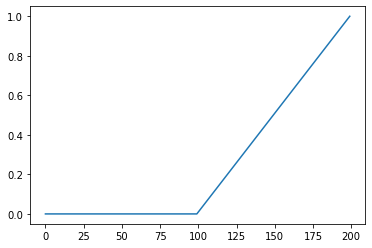

In [2]:
# non-zero coefs
K=100
# coefficients "weights" w (beta is reserved for the Half-Cauchy parameter below)
w = np.arange(1,K+1)/K
# noise coeffs
Q = 100
w = np.concatenate([np.zeros((1,Q)), w[np.newaxis,:]], axis=1).flatten()
plt.plot(w)

In [3]:
# number of subpopulations
P=1000
# randomly assigned characteristics
X = stats.bernoulli(p=0.5).rvs(size=(K+Q)*P).reshape(P,(K+Q))
X.shape

(1000, 200)

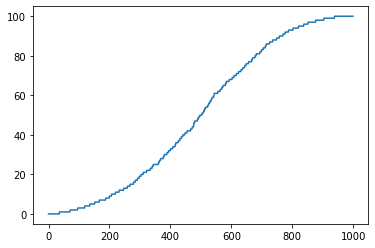

In [4]:
# sample size per subpopulation
N = 100
# fixed and assumed known intercept
THETA=-25
x = stats.binom(p=invlogit(THETA+X@w), n=[N]*P).rvs()
plt.plot(sorted(x))

Half-Cauchy ($HC_+$): $$f(x \mid \beta) = \frac{2\cdot 1_{[x>=0]}(x)}{\pi \beta \left[1 + \left(\frac{x}{\beta}\right)^2\right]} $$

Horseshoe Prior ($HSP$): 
\begin{align*}
w_i|\tau &\sim N(0, \sigma^2=\lambda_i^2\tau^2)\\
\lambda_i &\sim HC_+(0,1)\\
\tau &\sim HC_+(0,\tau_0)
\end{align*}



https://faculty.mccombs.utexas.edu/carlos.carvalho/Carvalhoetal2009.pdf

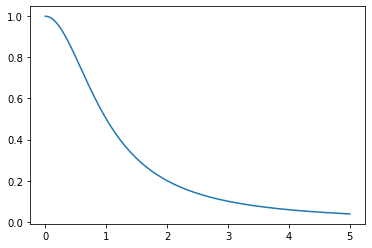

In [5]:
support = np.linspace(0,5,1000)
# posterior variance contribution from prior
shrinkage = 1/(1+support**2)
plt.plot(support, shrinkage)

In [6]:
with pm.Model() as mod:
    
    tau_0 = 1
    tau = pm.HalfCauchy('tau', beta=tau_0, shape=1)
    lambdas = pm.HalfCauchy('lambdas', beta=1, shape=(Q+K))
    weights = pm.Normal('weights', mu=0, sd=tau*lambdas, shape=(Q+K))
    successes = pm.Binomial('successes', p=tt_invlogit(X@weights+THETA), n=[N]*P,
                            observed=x)
    
with mod:
    posterior = pm.sample()    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, lambdas, tau]


ValueError: Not enough samples to build a trace.

Text(0.5, 1.0, 'The Horseshoe!')

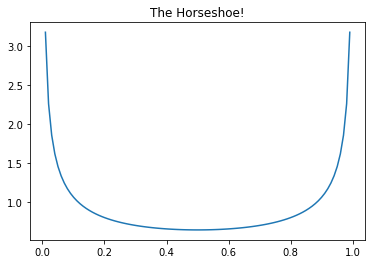

In [9]:
# change of variables
# shrnk = trans(spprt) = 1/(1+sprt**2)
# spprt = (1/shrnk-1)**0.5
# E.g., 1/(1+.5**2), (1/.8-1)**0.5
# jacobian: .5(1/shrnk-1)**(-.5)*shrnk**(-2)
shrinkage = np.linspace(0,1,100)
plt.plot(shrinkage, 
         stats.halfcauchy(scale=1).pdf((1/shrinkage-1)**0.5) * 
         .5*(1/shrinkage-1)**(-.5)*shrinkage**(-2))
plt.title('The Horseshoe!')

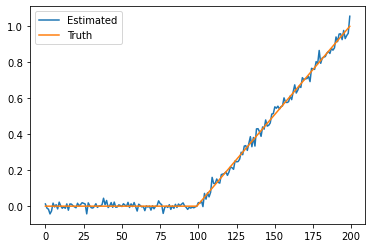

In [8]:
plt.plot(posterior['weights'].mean(axis=0), label='Estimated')
plt.plot(w, label='Truth')
plt.legend()

Text(0.5, 1.0, 'Shrinkage Profile')

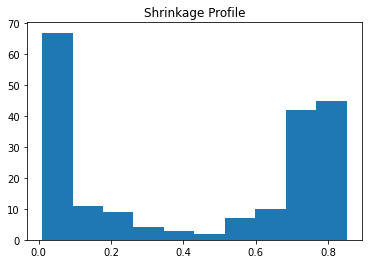

In [9]:
plt.hist(1/(1+posterior['lambdas'].mean(axis=0)**2))
plt.title('Shrinkage Profile')

# V2: Regularized Horseshoe Prior

- https://avehtari.github.io/modelselection/regularizedhorseshoe_slides.pdf
- https://www.youtube.com/watch?v=EuhvfvY8ISc
- https://arxiv.org/pdf/1707.01694.pdf

On Page 74 (and Figure 2) of the original horseshoe manuscript (Carvalhoetal2009.pdf) -- Carvalho, Polsen, and Scott 2009 -- the assumption that $\tau=\sigma=n=1$ is used to illustrate shrinkage as $\kappa_i=\frac{1}{1+\tau_j}$; however, a fuller form is given in Piironen and Vehtari 2017 (1707.01694.pdf); namely:

$$\frac{1}{1 + n \sigma^{-2}\tau^2 s_{x_j}^2 \lambda^2_j} = \frac{1}{1 + \frac{n}{ \sigma^2}\tau^2 \lambda^2_j}$$ 

if $Var(x_j) = s_{x_j}^2 = 1$, as in the case of standardized data. 

Piironen and Vehtari 2017 Further show that the *smaller* $\frac{n}{\sigma^2}\tau^2$ gets, the *greater* the number of parameters will be that experience shrinkage, and they formulate the 
following expectation on the effective number of parameters resulting from the choice of $\tau = \tau_0$:

- $E\left[ \sum_{k=1}^D 1 - \kappa_j \right] = \frac{\frac{\tau_0}{\sigma}\sqrt{n}}{1+\frac{\tau_0}{\sigma}\sqrt{n}}D$
- where $\tau_0 = \frac{p_0}{D-p_0}\frac{\sigma}{\sqrt{n}}$ 
- where $p_0$ is the number of "effectively non-zero" parameters and $D$ is the total number of parameters. 



Below we demonstrate the behavior of their proposed priors based on different choices of $\tau_0$

- $\tau = \tau_0$
- $N_+\left(􏰀0, \tau_0^2\right)$􏰁
- $C_+\left(􏰀0, \tau_0^2\right)$􏰁
- $C_+\left(􏰀0, 1\right)$􏰁




In [57]:
X@w_prime

array([ 8.55,  7.99, 10.1 ,  4.23,  5.  ,  8.22,  7.78,  6.18,  7.33,
        7.04,  5.56,  6.38,  7.92,  7.49,  4.56,  5.81,  8.4 ,  8.12,
        7.87,  8.02,  8.57,  7.35,  5.28,  5.83,  9.22,  5.76, 10.21,
        5.99,  3.96,  2.4 ,  5.53,  6.03,  8.11,  6.22,  7.88,  5.95,
        6.95,  7.71,  5.96,  4.  ,  8.56,  5.97,  7.17,  7.06,  6.99,
        4.23,  6.85,  6.17,  6.12,  8.25,  7.87,  4.56,  8.79,  6.26,
        6.33,  8.52,  7.67,  6.87,  6.45,  5.09,  8.6 ,  6.31,  6.95,
        6.09,  5.24,  5.3 ,  6.98,  4.47,  9.28,  6.11,  7.48,  7.58,
        5.71,  7.9 ,  6.87,  5.75, 10.28,  7.07,  5.77,  3.75,  6.28,
        6.42,  5.43,  7.74,  5.17,  6.91,  3.85,  3.82,  9.29,  5.59,
        8.48,  9.89,  6.23,  6.17,  5.47,  5.87,  7.64,  6.99,  7.41,
        6.25,  5.77,  7.18,  8.55,  8.23,  6.73,  8.83,  8.2 ,  8.58,
        4.81,  9.71,  7.97,  7.24,  7.32,  7.53,  7.64,  6.11,  5.23,
        6.85,  5.26,  5.98, 10.37,  6.85,  4.43,  9.84,  6.48,  8.11,
        8.99,  9.04,

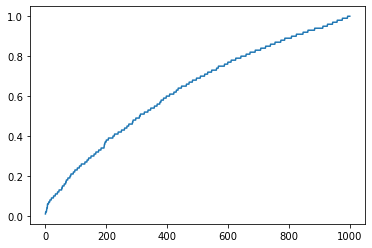

In [51]:
# zero out some coefficients

import random
w_prime = w.copy()
w_prime[random.sample(range(len(w)), 150)] = 0

THETA = -6
x = stats.binom(p=invlogit(THETA+X@w_prime), n=[N]*P).rvs()
plt.plot(sorted(x/N))

In [98]:
with pm.Model() as mod_reg_1p0:
    
    tau_0 = 1#.01
    #tau = pm.HalfCauchy('tau', beta=tau_0, shape=1)
    tau = tau_0
    lambdas = pm.HalfCauchy('lambdas', beta=1, shape=(Q+K))
    weights = pm.Normal('weights', mu=0, sd=tau*lambdas, shape=(Q+K))
    successes = pm.Binomial('successes', p=tt_invlogit(X@weights+THETA), n=[N]*P,
                            observed=x)
    
with mod_reg_1p0:
    posterior_reg_1p0 = pm.sample()    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, lambdas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 269 seconds.
There were 556 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6567554954983804, but should be close to 0.8. Try to increase the number of tuning steps.
There were 608 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5883855841523762, but should be close to 0.8. Try to increase the number of tuning steps.
There were 589 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5792905146786848, but should be close to 0.8. Try to increase the number of tuning steps.
There were 539 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6915559603229503, but should be close

In [100]:
with pm.Model() as mod_reg_0p01:
    
    tau_0 = 0.01
    #tau = pm.HalfCauchy('tau', beta=tau_0, shape=1)
    tau = tau_0
    lambdas = pm.HalfCauchy('lambdas', beta=1, shape=(Q+K))
    weights = pm.Normal('weights', mu=0, sd=tau*lambdas, shape=(Q+K))
    successes = pm.Binomial('successes', p=tt_invlogit(X@weights+THETA), n=[N]*P,
                            observed=x)
    
with mod_reg_0p01:
    posterior_reg_0p01 = pm.sample()    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, lambdas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 643 seconds.
There were 735 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7057983875570116, but should be close to 0.8. Try to increase the number of tuning steps.
There were 793 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6249111628696028, but should be close to 0.8. Try to increase the number of tuning steps.
There were 666 divergences after tuning. Increase `target_accept` or reparameterize.
There were 602 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


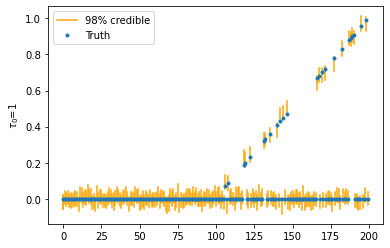

In [117]:
#plt.plot(posterior_reg['weights'].mean(axis=0), label='Estimated')
par_1p0 = np.array(2*[np.arange(len(posterior_reg_1p0['weights'].mean(axis=0)))])
val_1p0 = np.percentile(posterior_reg_1p0['weights'], [1, 99], axis=0)
plt.plot(par_1p0,val_1p0,'orange')
plt.plot(par_1p0[:,0],val_1p0[:,0],'orange', label='98% credible')
plt.plot(w_prime, '.', label='Truth')
plt.ylabel('$\\tau_0$=1')


plt.legend()

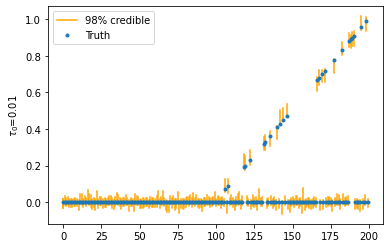

In [118]:
#plt.plot(posterior_reg['weights'].mean(axis=0), label='Estimated')
par_0p01 = np.array(2*[np.arange(len(posterior_reg_0p01['weights'].mean(axis=0)))])
val_0p01 = np.percentile(posterior_reg_0p01['weights'], [1, 99], axis=0)
plt.plot(par_0p01,val_0p01,'orange')
plt.plot(par_0p01[:,0],val_0p01[:,0],'orange', label='98% credible')
plt.plot(w_prime, '.', label='Truth')
plt.ylabel('$\\tau_0$=0.01')

plt.legend()

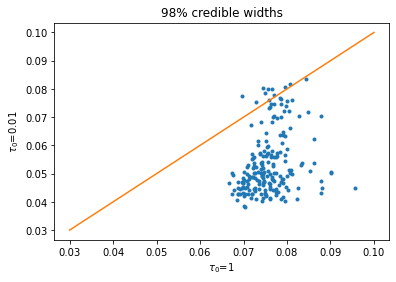

In [119]:
plt.plot(val_1p0[1]-val_1p0[0],val_0p01[1]-val_0p01[0],'.')
plt.xlabel('$\\tau_0$=1')
plt.ylabel('$\\tau_0$=0.01')
plt.title('98% credible widths')
plt.plot([.03,.1],[.03,.1])
